In [14]:
# building a model
from keras.models import Sequential                       # building a sequential model
from keras.layers import Conv2D                           # convolution layer
from keras.layers import MaxPooling2D                     # pooling layer
from keras.layers import Dropout                          # regularization, prevent overfitting
from keras.layers import Dense                            # fully connected layers
from keras.layers import GlobalMaxPooling2D, Flatten      # flattening for fully connected layers
from keras.optimizers import SGD

# dealing with images
from keras.preprocessing.image import ImageDataGenerator  # data augmentation
from keras.utils import to_categorical                    # classification
from sklearn.model_selection import train_test_split      # split training into train/test

# utilities
import random                                             # seed for train_test_split
import numpy as np                                        # linear algebra, of course
import pandas as pd                                       # reading csv and storing image data
import os                                                 # listing files
import matplotlib.pyplot as plt                           # plotting

In [2]:
data_dir = '../../catdog_input'                           # set the base data directory
training_dir = data_dir+'/train'                          # set the training directory
print(os.listdir(data_dir))                               # see which files are in the data directory

nb_train_imgs = len(os.listdir(training_dir))             # get the number of training images
print(nb_train_imgs, 'training images')                   # see how many training images there are

['train', 'sampleSubmission.csv', 'test1.zip']
25000 training images


In [3]:
imgs = os.listdir(training_dir)                           # list of image file names
labels = np.zeros((nb_train_imgs,), dtype='object')       # init. empty array for labels
for i, img in enumerate(imgs):                            # iterate over each image
    label = img.split('.')[0]                             # extract the class from file name
    if label == 'dog':                                    # if the label is dog, insert 1 to label array
        labels[i] = '1'
    else:                                                 # if the label is cat, insert 0 to label array
        labels[i] = '0'
        
df = pd.DataFrame({                                       # create dataframe to feed to keras
    'filename': imgs,                                     # image file names
    'category': labels                                    # class labels
})

for i in range(10):                                       # iterate over a few samples
    print(labels[i])                                      # print label

1
1
1
1
1
1
0
1
0
1


In [4]:
df.tail()  # ensure label matches filename

,category,filename
24995,0,cat.4228.jpg
24996,1,dog.2454.jpg
24997,1,dog.8236.jpg
24998,1,dog.2249.jpg
24999,1,dog.11217.jpg


In [6]:
img_wh = 128                           # image width and height
img_d = 3                              # number of channels, RGB is 3 channels
input_shape = (img_wh, img_wh, img_d)  # create shape for width, height, and channels

# a note on how padding='same' is calculated. here we use default strides of 1
#   out_height = ceil(float(img_wh) / float(strides[1]))
#   out_width  = ceil(float(img_wh)) / float(strides[2]))

# build a VGG style sequential model
model = Sequential([
    # block 1
    # 2 convolutions, each with:
    #    64 3x3 kernels,
    #    same padding (as described above),
    #    relu activation
    # and a maxpooling layer with strides of 2 and a window size of 2x2
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'), 
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # block 2
    # 2 convolutions, each with:
    #   128 3x3 kernels,
    #   same padding (as described above),
    #   relu activation
    # and a maxpooling layer with strides of 2 and a window size of 2x2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # block 3
    # 3 convolutions, each with: 
    #   256 3x3 kernels,
    #   same padding (as described above),
    #   relu activation
    # and a maxpooling layer with strides of 2 and a window size of 2x2
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # block 4
    # 3 convolutions, each with:
    #   512 3x3 kernels,
    #   same padding (as described above),
    #   relu activation
    # and a maxpooling layer with strides of 2 and a window size of 2x2
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # block 5
    # 3 convolutions, each with:
    #   512 3x3 kernels,
    #   same padding (as described above),
    #   relu activation
    # and a maxpooling layer with strides of 2 and a window size of 2x2
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # top 
    Flatten(),                      # flatten into 1D for fully connected layers
    Dense(512, activation='relu'),  # fully connected layer with activation relu 
    Dropout(0.5),                   # regularization to prevent overfitting
    Dense(1, activation='sigmoid')  # final sigmoid for classification
])

# compile with model with binary cross entropy, as this is a binary classifcation problem,
# and use stochastic gradient descent with a learning rate of 0.0001
# and a momentum of 0.9 to help accelerate gradient in the right direction
# and meausure fitness by accuracy
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-3, momentum=0.9, nesterov=True), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       295168    
__________

In [7]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)  # split the training in train/test
train_df = train_df.reset_index(drop=True)                                     # remove index column
validate_df = validate_df.reset_index(drop=True)                               # remove index column 

In [8]:
total_train = train_df.shape[0]        # get the total number of training images
total_validate = validate_df.shape[0]  # get the total number of validation images

print(total_train)                     # print number of training images
print(total_validate)                  # print number of validation images

20000
5000


In [9]:
train_datagen = ImageDataGenerator(  # generates images with augmentations specified below
    rotation_range=15,               # rotate image 15 degrees
    rescale=1./255,                  # target values between 0 and 1
    shear_range=0.1,                 # counter-clockwise rotation
    zoom_range=0.2,                  # zoom into image
    horizontal_flip=True,            # allow horizontal flip
    width_shift_range=0.1,           # shift width
    height_shift_range=0.1           # shift height
)

# parameters
flow_training_dir = training_dir+'/' # directory to flow images from
img_dim = (img_wh, img_wh)           # set image dimensions without channels
batch_size = 15                      # number of images to feed model at a time

# create the image flow for training
train_generator = train_datagen.flow_from_dataframe(
    train_df,                        # dataframe of images and labels
    flow_training_dir,               # directory to flow from
    x_col='filename',                # specifying name of image identifier in dataframe
    y_col='category',                # specifying name of label identifier in dataframe
    target_size=img_dim,             # image dimensions without channels
    class_mode='binary',             # binary classification: cat/dog
    batch_size=batch_size            # number of images to process at a time
)

Found 20000 images belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)  # target values between 0 and 1

# create image flow for validation
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,                     # datagframe of images and labels
    flow_training_dir,               # directory to flow from
    x_col='filename',                # specifying name of image identifier in dataframe
    y_col='category',                # specifying name of label identifier in dataframe
    target_size=img_dim,             # image dimensions without channels
    class_mode='binary',             # binary classification: cat/dog
    batch_size=batch_size            # number of images to process at a time
)

Found 5000 images belonging to 2 classes.


In [11]:
nb_epochs = 25                                     # number of iterations
history = model.fit_generator(                     # start fitting the data!
    train_generator,                               # training image data generator
    epochs=nb_epochs,                              # number of iterations
    validation_data=validation_generator,          # validation image data generator
    validation_steps=total_validate//batch_size,   # number of validation steps
    steps_per_epoch=total_train//batch_size        # number of steps per epoch
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
1333/1333 [==============================] - 766s 574ms/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6930 - val_acc: 0.4949
Epoch 2/25
1333/1333 [==============================] - 329s 247ms/step - loss: 0.6927 - acc: 0.5155 - val_loss: 0.6920 - val_acc: 0.4969
Epoch 3/25
1333/1333 [==============================] - 329s 247ms/step - loss: 0.6898 - acc: 0.5368 - val_loss: 0.6785 - val_acc: 0.5896
Epoch 4/25
1333/1333 [==============================] - 329s 247ms/step - loss: 0.6786 - acc: 0.5725 - val_loss: 0.6604 - val_acc: 0.6142
Epoch 5/25
1333/1333 [==============================] - 328s 246ms/step - loss: 0.6662 - acc: 0.5957 - val_loss: 0.6457 - val_acc: 0.6100
Epoch 6/25
1333/1333 [==============================] - 327s 246ms/step - loss: 0.6463 - acc: 0.6154 - val_loss: 0.6068 - val_acc: 0.6560
Epoch 7/25
1333/1333 [==============================] - 328s 246ms/step - loss: 0.6284 - acc: 0.6349 - val_loss: 0.6163 - va

In [12]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.922367  ;  loss = 0.193437 


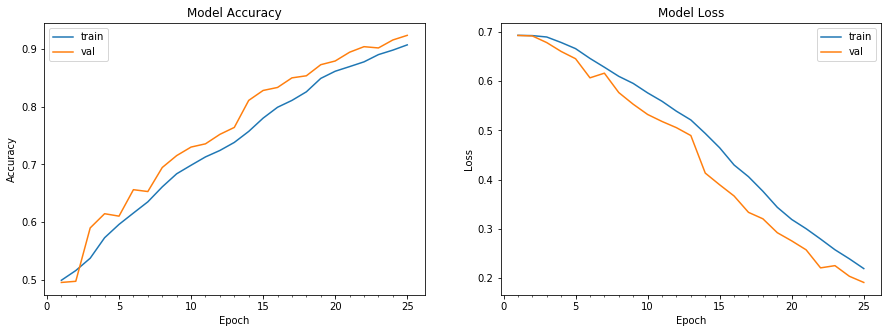

In [15]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)